In [1]:
import os
import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

import setGPU

I0520 01:22:00.720196 140025617741632 file_utils.py:38] PyTorch version 1.4.0 available.
I0520 01:22:00.723218 140025617741632 file_utils.py:54] TensorFlow version 2.1.0 available.


setGPU: Setting GPU to: 0


In [2]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [4]:
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path=None, num_class=None):
        super(TFGPT2Classifier, self).__init__()
        
        self.dir_path = 'gpt2' if dir_path is None else dir_path
        
        self.gpt2 = TFGPT2Model.from_pretrained(self.dir_path)
        self.num_class = self.gpt2.config.num_labels if num_class is None else num_class
        
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        pooled_output = outputs[0][:, -1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:] 

        return outputs

In [5]:
TOKENIZER_PATH = './gpt_ckpt/kogpt2_news_wiki_ko_cased_818bfa919d.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token='<unused0>',
                                               cls_token='<unused1>',
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

In [6]:
tf.random.set_seed(0)
np.random.seed(0)

BATCH_SIZE = 384
NUM_EPOCHS = 3
VALID_SPLIT = 0.1
SENT_MAX_LEN = 39
MAX_LEN = SENT_MAX_LEN + 3
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [14]:
# 데이터 전처리 준비

DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_train.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_test.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)
train_data = train_data.dropna()
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [15]:
# 텍스트 전처리

def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent)
    return sent_clean

In [16]:
# train_data = train_data[:50] # for test

train_data_sents = list()
train_data_labels = list()

for train_sent, train_label in zip(train_data['document'], train_data['label']):
    tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(clean_text(train_sent))][:SENT_MAX_LEN] + \
             [vocab[vocab.eos_token], vocab[vocab.cls_token]]
    train_data_sents.append(tokens)
    train_data_labels.append(train_label)

train_data_sents = pad_sequences(train_data_sents, MAX_LEN - 1, value=vocab[vocab.padding_token])

train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

In [10]:
cls_model = TFGPT2Classifier('./gpt_ckpt')

I0520 01:22:03.993028 140025617741632 configuration_utils.py:252] loading configuration file ./gpt_ckpt/config.json
I0520 01:22:03.995092 140025617741632 configuration_utils.py:290] Model config GPT2Config {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "embd_pdrop": 0.1,
  "eos_token_ids": null,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_beams": 1,
  "num_labels": 2,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": null,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "resid_pdrop": 0.

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [18]:
model_name = "tf2_gpt2_naver_movie"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = cls_model.fit(train_data_sents, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

data_out/KOR/tf2_gpt2_naver_movie -- Folder already exists 

Train on 134995 samples, validate on 15000 samples
Epoch 1/3
134784/134995 [============================>.] - ETA: 0s - loss: 0.4123 - accuracy: 0.8040
Epoch 00001: val_accuracy improved from -inf to 0.86107, saving model to data_out/KOR/tf2_gpt2_naver_movie/weights.h5
134995/134995 [==============================] - 388s 3ms/sample - loss: 0.4122 - accuracy: 0.8041 - val_loss: 0.3185 - val_accuracy: 0.8611
Epoch 2/3
134784/134995 [============================>.] - ETA: 0s - loss: 0.3099 - accuracy: 0.8657
Epoch 00002: val_accuracy improved from 0.86107 to 0.87453, saving model to data_out/KOR/tf2_gpt2_naver_movie/weights.h5
134995/134995 [==============================] - 374s 3ms/sample - loss: 0.3099 - accuracy: 0.8656 - val_loss: 0.2886 - val_accuracy: 0.8745
Epoch 3/3
134784/134995 [============================>.] - ETA: 0s - loss: 0.2821 - accuracy: 0.8788
Epoch 00003: val_accuracy improved from 0.87453 to 0.88167, savi

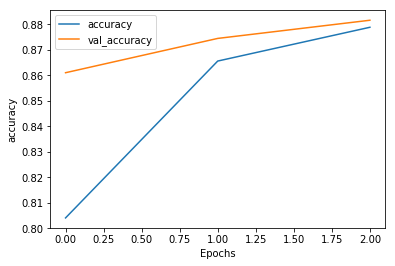

In [19]:
plot_graphs(history, 'accuracy')

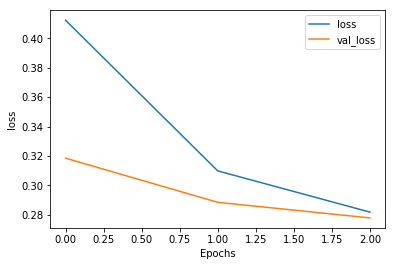

In [20]:
plot_graphs(history, 'loss')

# Bag of Words Test Dataset (제출 확인 필요)

In [21]:
test_data = pd.read_csv(DATA_TEST_PATH, header = 0, delimiter = '\t', quoting = 3)
test_data = test_data.dropna()
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [22]:
# test_data = test_data[:50] # for test

test_data_sents = list()
test_data_labels = list()

for test_sent, test_label in zip(test_data['document'], test_data['label']):
    tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(clean_text(test_sent))][:SENT_MAX_LEN] + \
             [vocab[vocab.eos_token], vocab[vocab.cls_token]]
    test_data_sents.append(tokens)
    test_data_labels.append(test_label)

test_data_sents = pad_sequences(test_data_sents, MAX_LEN - 1, value=vocab[vocab.padding_token])

test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [23]:
print("num sents, labels {}, {}".format(len(test_data_sents), len(test_data_labels)))

num sents, labels 49997, 49997


In [24]:
results = cls_model.evaluate(test_data_sents, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)

49997/49997 [==============================] - 46s 917us/sample - loss: 0.2892 - accuracy: 0.8771
test loss, test acc:  [0.289237498087814, 0.87713265]
